This jupyter notebook is a part of imaging tutorials at https://github.com/zoeye859/Imaging-Tutorial/tree/master
Here, we try use spheroidal function as the gridding function.

In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
np.set_printoptions(precision=16)


In [2]:
# Download a data in the .csv form - which is very unusual, the visibility data is usulaly stored in .ms files
!wget https://raw.githubusercontent.com/zoeye859/Imaging-Tutorial/master/onesource.csv

zsh:1: command not found: wget


In [3]:
#########  Read in visibilities ##########
X_size = 400 #image size on x-axis
Y_size = 400 #image size on y-axis
Vis = np.loadtxt('onesource.csv', usecols = range(0,5)) # read in visibilities
u = np.transpose(Vis)[0] #u values
v = np.transpose(Vis)[1] #v values
w = np.transpose(Vis)[2] #w values
jj = complex(0,1)
V = np.transpose(Vis)[3] + jj * np.transpose(Vis)[4] #complex visibility values
n_uv = len(u) #length of the data

In [4]:
#### Determine the pixel size ####
X_min = -np.pi / 129600. * 2 #You can change X_min and X_max in order to change the pixel size.
X_max = np.pi / 129600. * 2 
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -np.pi / 129600. * 2 #You can change Y_min and Y_max in order to change the pixel size.
Y_max = np.pi / 129600. * 2 
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]

pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size #pixel size on x-axis
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size #pixel size on y-axis
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  0.05  arcsec


### 1. Make a DFT dirty map again
Here I will just read the results from Tutorial 1 to save some time and computaiontal resources.

In [7]:
!wget https://raw.githubusercontent.com/zoeye859/Imaging-Tutorial/master/slowmap.csv
I_sum = np.loadtxt('slowmap.csv', delimiter = ',') ## 200*200

zsh:1: command not found: wget


### 2. Use the spheroidal function and calculate its corresponding correcting function

#### 2.1 Predefined functions

In [8]:
def make_evaluation_grids(W, M, N):
    """Generate vectors nu and x on which the gridder and gridding correction functions need to be evaluated.
        W is the number of integer gridpoints in total 
        M determines the sampling of the nu grid, dnu = 1/(2*M)
        N determines the sampling of the x grid, dx = 1/(2*N)
    """
    nu = (np.arange(W * M, dtype=float) + 0.5) / (2 * M)
    x = np.arange(N+1, dtype=float)/(2 * N)
    return nu, x

def calc_gridder_as_C_old(h, x0, nu, R):
    # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1. 
    #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
    # The gridding function is calculated for l=-R+1 to R at points nu
    M = len(nu)
    C = np.zeros((W, M), dtype=float)
    K = np.zeros((W, W))
    N = len(h)
    x = x0 * np.arange(0, N+1, dtype=float)/N
    dx = x0 / N
    h_ext = np.concatenate(([1.0], h))
    
    for rp in range(0, W):
        lp = rp - (W/2) + 1
        for r in range(W):
            l = r -  (W/2) + 1
            K[rp, r] = trap((h_ext**2) * np.cos(2 * np.pi * (lp - l) * x), dx)
    #Kinv = np.linalg.pinv(K)
    
    rhs = np.zeros(W, dtype=float)
    for m, nu_val in enumerate(nu):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            rhs[rp] = trap(h_ext * np.cos(2 * np.pi * (lp - nu_val) * x), dx)
        C[:,m] = np.linalg.lstsq(K, rhs, 1e-14)[0]
        # C[:,m] = np.dot(Kinv, rhs)
    return C

def calc_gridder_as_C(h, x0, nu, W):
    # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1. 
    #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
    # The gridding function is calculated for l=(1-W)/2 to (W-1)/2 at points nu
    factor = 1./np.sqrt(2.)
    M = len(nu)
    C = np.zeros((W, M), dtype=float)
    N = len(h)
    B = np.zeros((2 * N + 2, W))
    x = x0 * np.arange(0, N+1, dtype=float)/N
    dx = x0 / N
    h_ext = np.concatenate(([1.0], h))
    
    rhs = np.r_[np.ones(N + 1, dtype=float), np.zeros(N + 1, dtype=float)]
    rhs[0] = rhs[0]*factor
    rhs[N] = rhs[N]*factor

    for m, nu_val in enumerate(nu):
        for r in range(W):
            k = r - (W/2) + 1
            B[:N+1, r] = h_ext * np.cos(2 * np.pi * (k - nu_val) * x)
            B[N+1:, r] = h_ext * np.sin(2 * np.pi * (k - nu_val) * x)
        B[0, :] = B[0, :]*factor
        B[N, :] = B[N, :]*factor
        B[N+1, :] = B[N+1, :]*factor
        B[2*N+1, :] = B[2*N+1, :]*factor
#        q, r = np.linalg.qr(B)
#        C[:,m] = solve_triangular(r,np.dot(q.transpose(),rhs))
        C[:,m] = np.linalg.lstsq(B, rhs)[0]
    return C

def calc_gridder_as_C_odd(h, x0, nu, W):
    # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1. 
    #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
    # The gridding function is calculated for l=(1-W)/2 to (W-1)/2 at points nu
    factor = 1./np.sqrt(2.)
    M = len(nu)
    C = np.zeros((W, M), dtype=float)
    N = len(h)
    B = np.zeros((2 * N + 2, W))
    x = x0 * np.arange(0, N+1, dtype=float)/N
    dx = x0 / N
    h_ext = np.concatenate(([1.0], h))
    
    rhs = np.r_[np.ones(N + 1, dtype=float), np.zeros(N + 1, dtype=float)]
    rhs[0] = rhs[0]*factor
    rhs[N] = rhs[N]*factor

    for m, nu_val in enumerate(nu):
        for r in range(W):
            if nu_val > 0.5:
                k = r - (W//2) + 1
            else:
                k = r - (W//2) 
            B[:N+1, r] = h_ext * np.cos(2 * np.pi * (k - nu_val) * x)
            B[N+1:, r] = h_ext * np.sin(2 * np.pi * (k - nu_val) * x)
        B[0, :] = B[0, :]*factor
        B[N, :] = B[N, :]*factor
        B[N+1, :] = B[N+1, :]*factor
        B[2*N+1, :] = B[2*N+1, :]*factor
#        q, r = np.linalg.qr(B)
#        C[:,m] = solve_triangular(r,np.dot(q.transpose(),rhs))
        C[:,m] = np.linalg.lstsq(B, rhs)[0]
    return C


def calc_gridder(h, x0, nu, W):
    # Calculate gridder function on a grid nu which should have been generated using make_evaluation_grids
    #  The array h is the result of an optimization process for the gridding correction function evaluated
    #  on a relatively coarse grid extending from 0 to x0
    C = calc_gridder_as_C(h, x0, nu, W)
    gridder = np.zeros(M*W, dtype=float)
    for m in range(M):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            indx = int(m - 2*lp*M)
            if indx >= 0:
                gridder[indx] = C[rp, m]
            else:
                gridder[-indx-1] = C[rp, m]
    return gridder

def gridder_to_C(gridder, W):
    """Reformat gridder evaluated on the nu grid returned by make_evaluation_grids into the sampled C function 
    which has an index for the closest gridpoint and an index for the fractional distance from that gridpoint
    """
    M = len(gridder) // W
    C = np.zeros((W, M), dtype=float)
    for r in range(0, W):
        l = r - (W/2) + 1
        indx = (np.arange(M) - 2 * M * l).astype(int)
        # Use symmetry to deal with negative indices
        indx[indx<0] = -indx[indx<0] - 1
        C[r, :] = gridder[indx]
    return C
    
def gridder_to_grid_correction(gridder, nu, x, W):
    """Calculate the optimal grid correction function from the gridding function. The vectors x and nu should
    have been constructed using make_evaluation_grids"""
    M = len(nu) // W
    N = len(x) - 1
    dnu = nu[1] - nu[0]
    C = gridder_to_C(gridder, W)
    c = np.zeros(x.shape, dtype=float)
    d = np.zeros(x.shape, dtype=float)
    for n, x_val in enumerate(x):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            for r in range(0, W):
                l = r - (W/2) + 1
                d[n] += np.sum(C[rp, :] * C[r, :] * np.cos(2 * np.pi * (lp - l) * x_val)) * dnu
            c[n] += np.sum(C[rp, :] * np.cos(2 * np.pi * (lp - nu[:M]) * x_val)) * dnu
    return c/d

def calc_map_error(gridder, grid_correction, nu, x, W):
    M = len(nu) // W
    N = len(x) - 1
    dnu = nu[1] - nu[0]
    C = gridder_to_C(gridder, W)
    loss = np.zeros((len(x), 2, M), dtype=float)
    for n, x_val in enumerate(x):
        one_app = 0
        for r in range(0, W):
            l = r - (W/2) + 1
            one_app += grid_correction[n] * C[r, :] * np.exp(2j * np.pi * (l - nu[:M]) * x_val)
        loss[n, 0, :] = 1.0 - np.real(one_app)
        loss[n, 1, :] = np.imag(one_app)
    map_error = np.zeros(len(x), dtype=float)
    for i in range(len(x)):
        map_error[i] = 2 * np.sum((loss[i, :, :].flatten())**2) * dnu
    return map_error

#### 2.2 Use the spheroidal function with width = 6

As discussed in the paper $\textit{Optimal Gridding and Degridding in Radio Interferometry}$ https://arxiv.org/abs/1906.07102. There are two ways to calculate the correcting function given the gridding function:

1. $h(x) = \frac{1}{c(x)}$ where $c(x)$ is the Fourier transform of the given gridding function

2. $h(x) = c(x)\bigg/ \sum_{n=-\infty}^{\infty} c(x-n)^2$ 

We have $\ell(x)$, which is proportional to the upper bound of the difference between the DFT and FFT dirty images, written as

$\ell(x) = 1-h(x)\int_0^1\mathrm{d}\nu\sum_rC(r-\nu)\cos[2\pi(r-\nu)x]= 1-h(x)c(x)$

Therefore, in the portions of the map where $\ell(x)$ is small, $h(x)\approx 1/c(x)$, which is the most commonly used correcting function formula. When we use the least--misfit gridding functions, we retain only the portion of the map with $|x|\leq x_0$. In this central portion, the difference between $1/c(x)$ and the optimal $h(x)$ is negligible.


In [9]:
## spheroidal function with alpha = 1
from scipy.special import pro_ang1
def C(u):
    return (1-(u/W*2)**2)**0.5 * pro_ang1(1, 1, W/2*np.pi, u/W*2)[0]


#### 2.3 Gridding Process

In [11]:
W = 6
im_size = 400
u_grid = u * (X_max - X_min) + im_size//2
v_grid = v * (Y_max - Y_min) + im_size//2
V_grid = np.zeros((im_size,im_size),dtype = np.complex_) #gridded visibility
bEAM = np.ones(n_uv)
B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
R = W//2

## Calculating gridding values for each vis data
t1_start = process_time() 
for k in range(0,n_uv):
    tempu = u_grid[k] - np.floor(u_grid[k])
    tempv = v_grid[k] - np.floor(v_grid[k])
    u_index = np.int(np.floor(u_grid[k]))
    v_index = np.int(np.floor(v_grid[k]))
    for m in range(-R+1,R+1):
        for n in range(-R+1,R+1):
                V_grid[u_index+m,v_index+n] += C(-tempu+m) * C(-tempv+n) * V[k] 
                B_grid[u_index+m,v_index+n] += C(-tempu+m) * C(-tempv+n) * bEAM[k]
    

t1_stop = process_time()   
print("Elapsed time during the gridding value calculation in seconds:", t1_stop-t1_start)  


/var/folders/5m/rzfqvwl90x5_wmbtwy9nyj_40000gn/T/ipykernel_35896/2318463247.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_index = np.int(np.floor(u_grid[k]))
/var/folders/5m/rzfqvwl90x5_wmbtwy9nyj_40000gn/T/ipykernel_35896/2318463247.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

Elapsed time during the gridding value calculation in seconds: 1.1029990000000005


#### 2.4 FFT Process

In [12]:
II = np.fft.ifftshift(V_grid)
II = np.fft.ifftn(II)
II = np.fft.ifftshift(II)
I_image = II*im_size*im_size/n_uv ## normalization

SB = np.fft.ifftshift(B_grid)
SB = np.fft.ifftn(SB)
SB = np.fft.ifftshift(SB)
B_image = SB*im_size*im_size/n_uv ## normalization


#### 2.6 Calculate the correcting function and obtain the FFT images

In [13]:
## Calculating the correcting function h_map
W = 6
M = 32
Nfft = 400
nu, x = make_evaluation_grids(W, M, Nfft/2)
gridder = (1-(nu/W*2)**2)**0.5* pro_ang1(1, 1, W/2*np.pi, nu/W*2)[0]
grid_correction = gridder_to_grid_correction(gridder, nu, x, W)
h_map = np.zeros(Nfft, dtype=float)
h_map[Nfft//2:] = grid_correction[:Nfft//2]
h_map[:Nfft//2] = grid_correction[:0:-1]

## correcting the FFT Dirty Beam
B_image_corrected = np.zeros((X_size, Y_size),dtype = np.complex_)
for i in range(0,im_size):
    for j in range(0,im_size):
        B_image_corrected[i,j] = B_image[i,j] * h_map[i] * h_map[j]

## correcting the FFT Dirty Map
I_image_corrected = np.zeros((X_size, Y_size),dtype = np.complex_)
for i in range(0,im_size):
    for j in range(0,im_size):
        I_image_corrected[i,j] = I_image[i,j] * h_map[i] * h_map[j]


#### 2.7 Crop and plot the FFT images

<IPython.core.display.Javascript object>


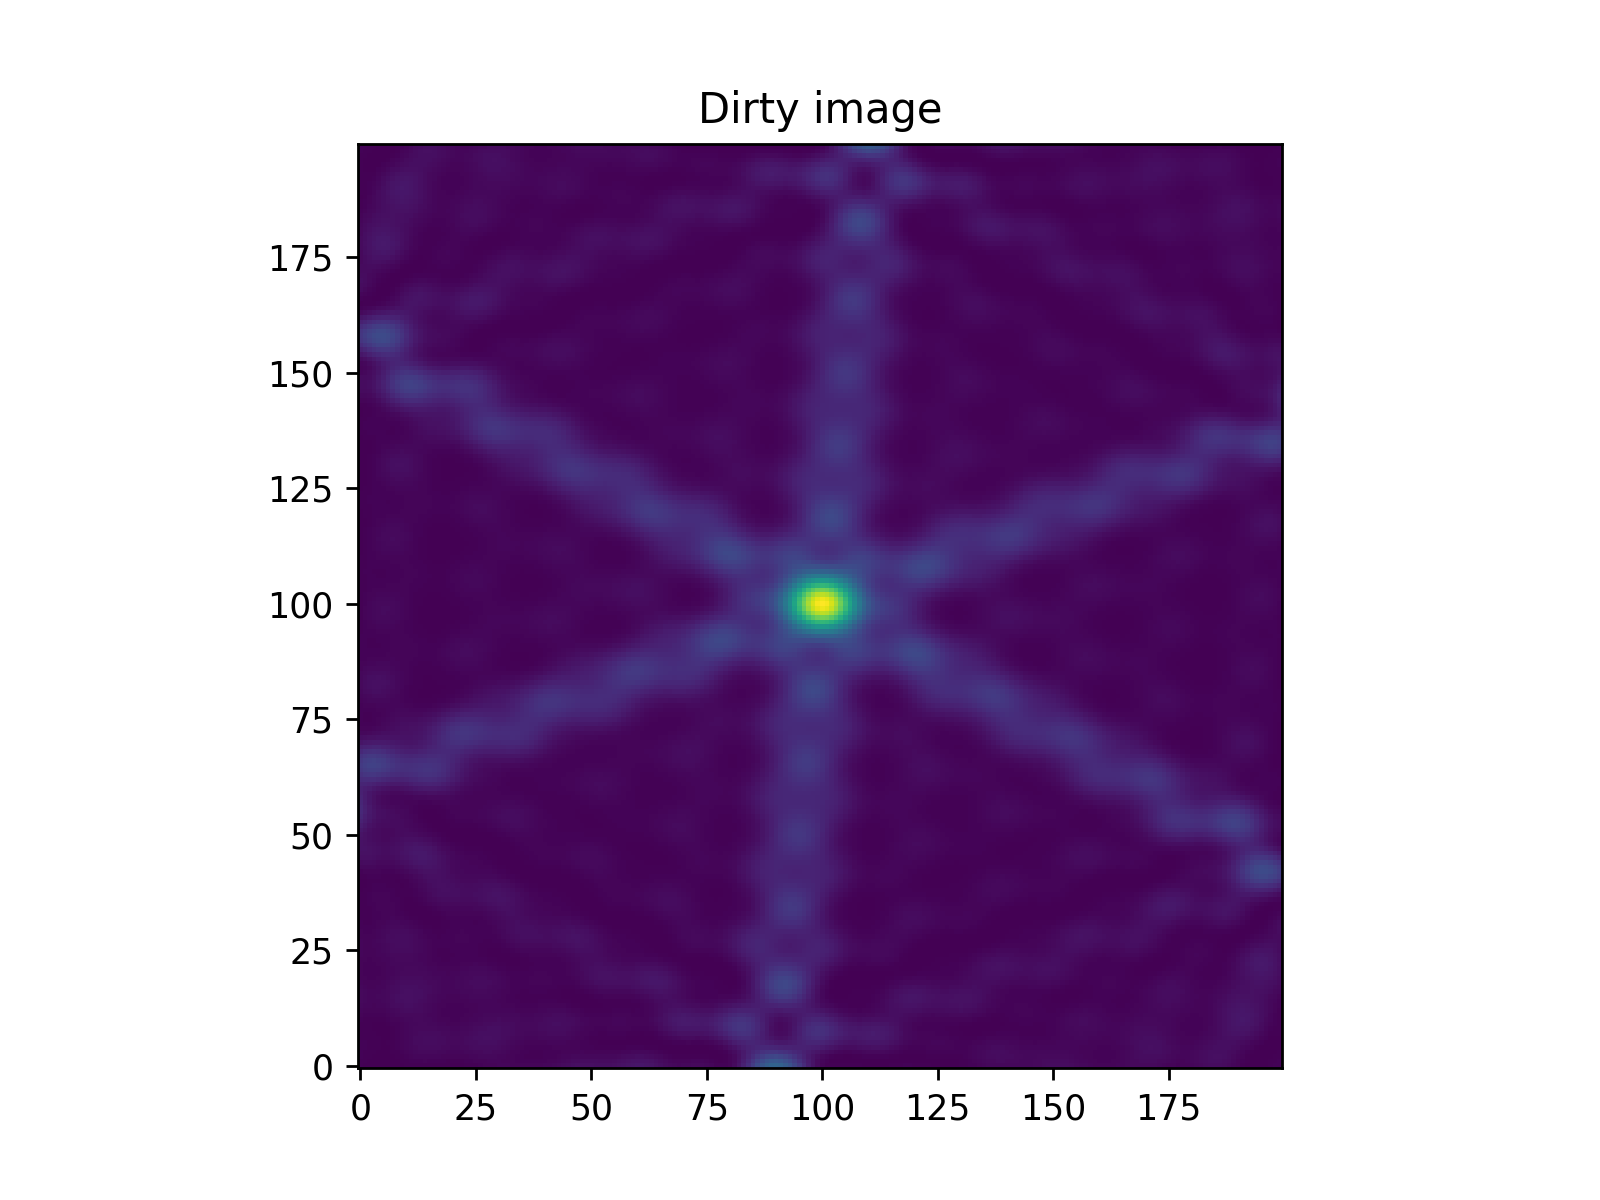

<IPython.core.display.Javascript object>


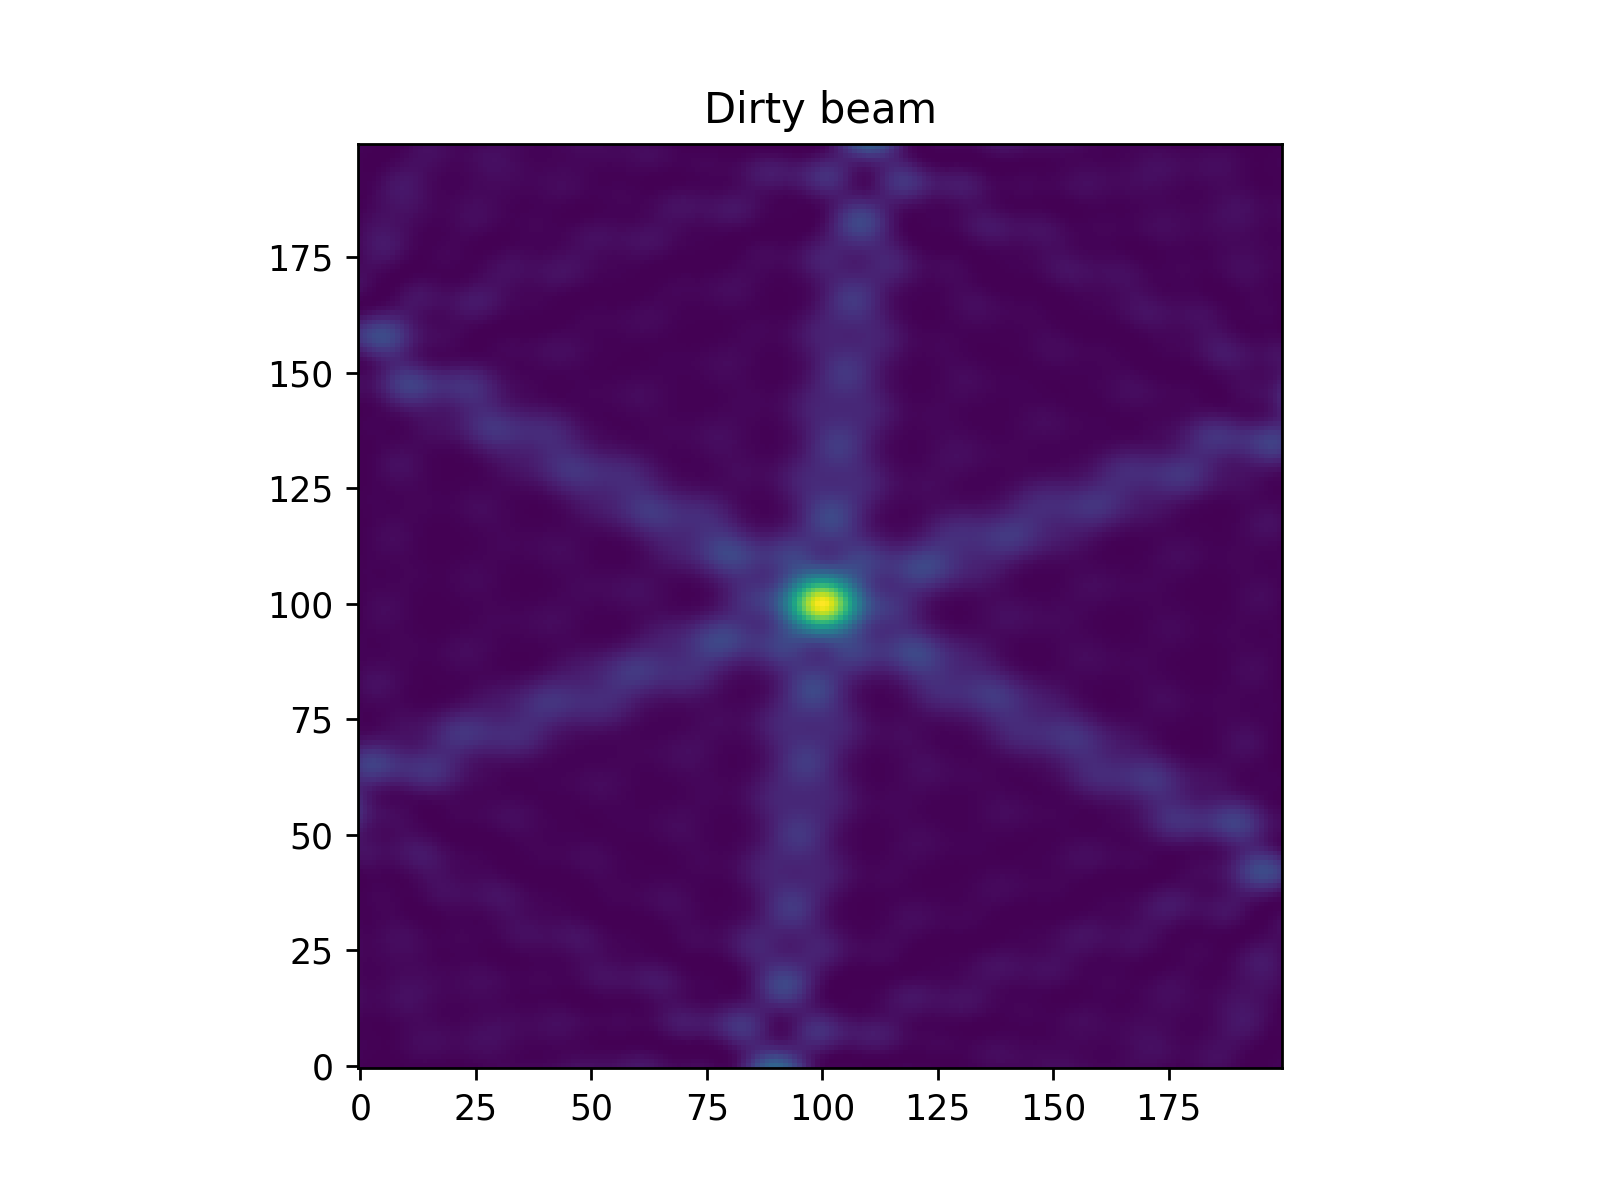

In [14]:
## Crop the two images (the cropping can be done before applyting the correcting function to save computational cost)

temp = np.delete(I_image_corrected,np.s_[0:X_size//4],0)
temp = np.delete(temp,np.s_[X_size//2:int(X_size * 0.75)],0)
temp = np.delete(temp,np.s_[0:Y_size//4],1)
I_image_corrected_crop = np.delete(temp,np.s_[Y_size//2:int(Y_size * 0.75)],1)

temp = np.delete(B_image_corrected,np.s_[0:X_size//4],0)
temp = np.delete(temp,np.s_[X_size//2:int(X_size * 0.75)],0)
temp = np.delete(temp,np.s_[0:Y_size//4],1)
B_image_corrected_crop = np.delete(temp,np.s_[Y_size//2:int(Y_size * 0.75)],1)


## demonstrate the dirty image and dirty beam directly
plt.figure()
plt.imshow(I_image_corrected_crop.real, origin = 'lower')
plt.title('Dirty image')
plt.figure()
plt.imshow(B_image_corrected_crop.real, origin = 'lower')
plt.title('Dirty beam')
plt.show()

### 3. Compare the FFT and DFT dirty images

<IPython.core.display.Javascript object>


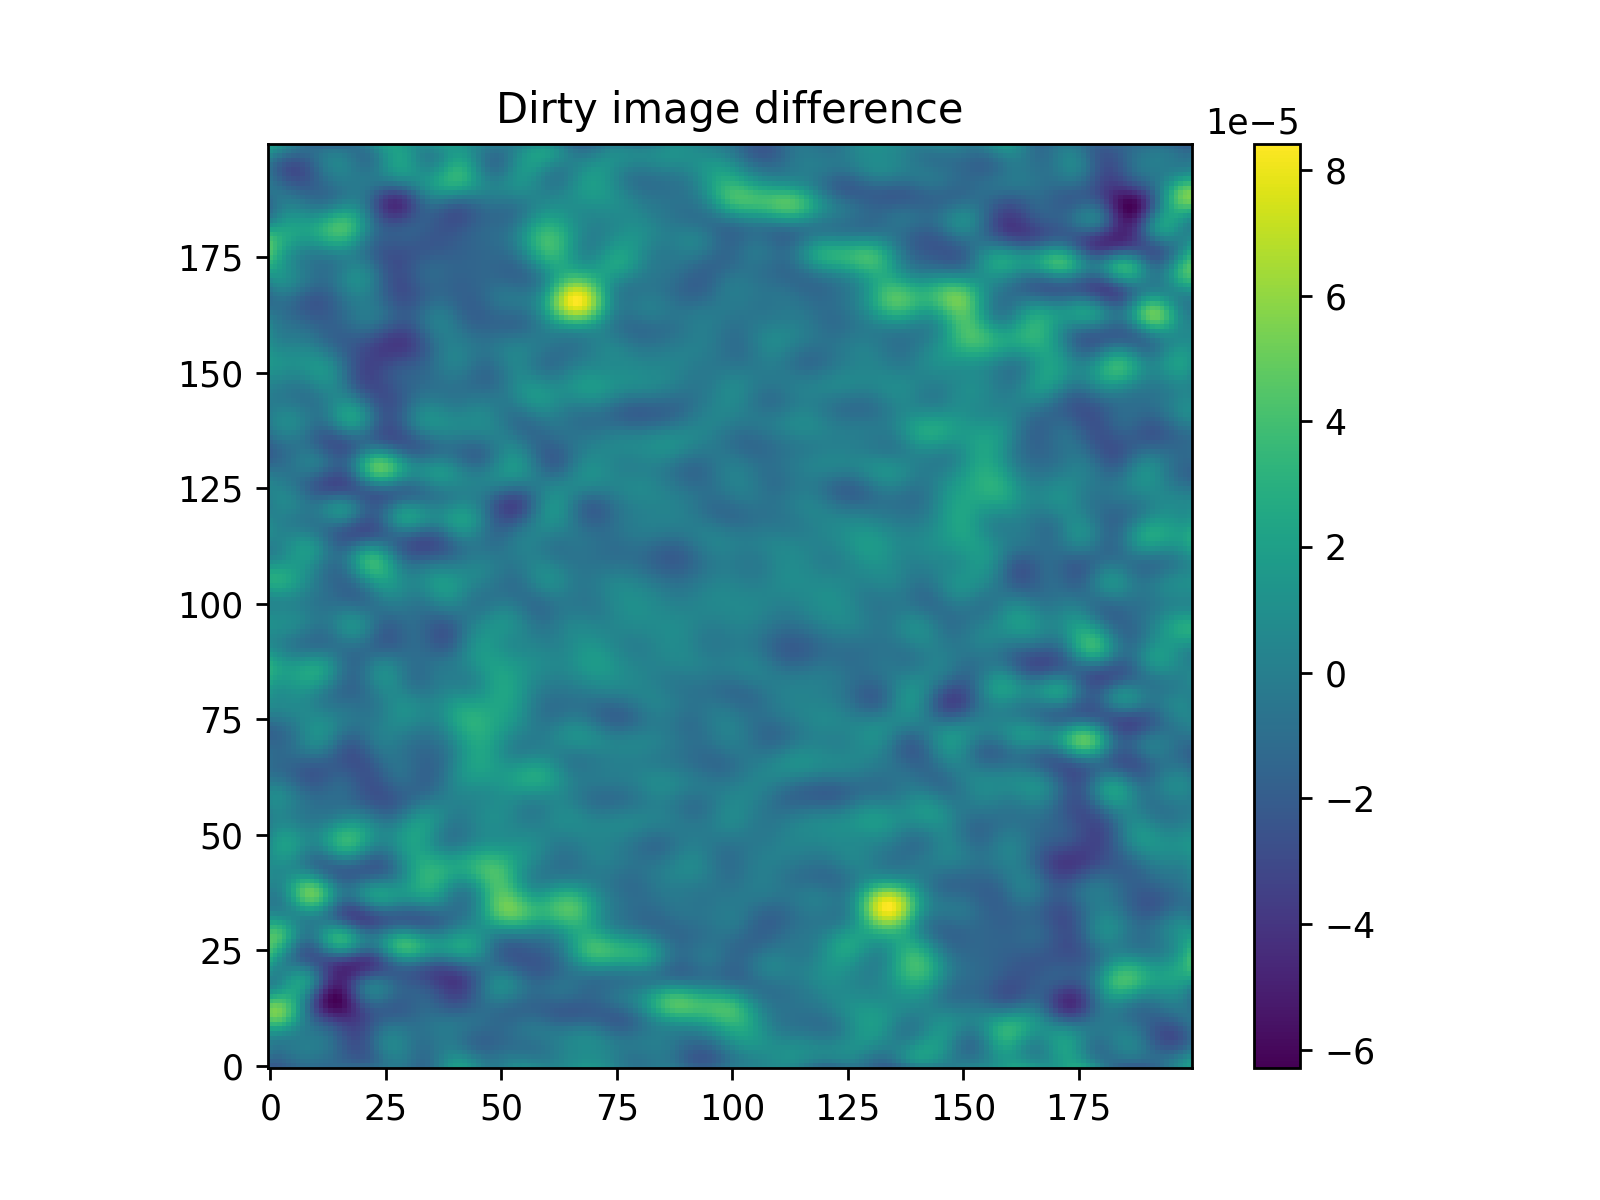

In [15]:
plt.figure()
plt.imshow(I_sum - I_image_corrected_crop.real, origin = 'lower')
plt.title('Dirty image difference')
plt.colorbar()
plt.show()